# k-Means

The $K$-Means algorithm is an unsupervised machine learning method. It aims to take a cloud of points and to group them automatically into several **clusters** with 'similar' features. For this reason, this algorithm (and all with similar goals) are known as **clustering methods**.

Notice that this is no longer supervised learning: there are no labels so there is not a 'right answer'.

To show how it works, let us prepare a synthetic dataset. We generate samples of two types according to two normal (gaussian) distributions with different means.

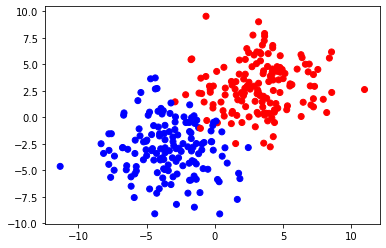

In [1]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=[[-3,-3], [3,3]], cluster_std=2.5)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr)

Since we are working in the unsupervised setting, the algorithm is not able to see the real labels of each cluster (represented in blue and red here). Instead, what it sees is an undistinguishable cloud of points so the cluster must be created with 'color-blindness'.

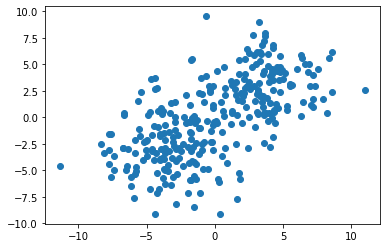

In [2]:
plt.figure()
plt.scatter(X[:,0], X[:,1])

The algorithm run by $K$-means is quite simple, but somehow paradigmatic of these types of methods. The idea is to create a Voronoi diagram in which each cluster is determined by a 'representative point', called the centroid. Each centroid captures all the points that are closest to it compared with the other centroids. With these clusters computed, the centroids are subsequently changed to the center of gravity, slightly modifying the clusters. 

To be precise, the steps are the following.

1.   A number of clusters (*k*) is fixed.
2.   *k* centroids are initialized at random. There are several strategies for this: drawing a point uniformly within the rank of values, or picking *k* real samples (Forgy method), or assigning randomly each point to a cluster (random partition method).
3.   Each sample of the dataset is assigned to its closed centroid.
4.   The centroids are updated with the mean value (the center of gravity) of the points in their clusters.
5.   Steps 3-4 are repeated until convergence (or for a certain amount of iterations).

Let us show the execution with the `skearn` implementation of [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

The following images show the first 4 iterations of an execution for 2 clusters ($k=2$). Notice that the centroids are subsequently moving towards the previously generated clouds of points.

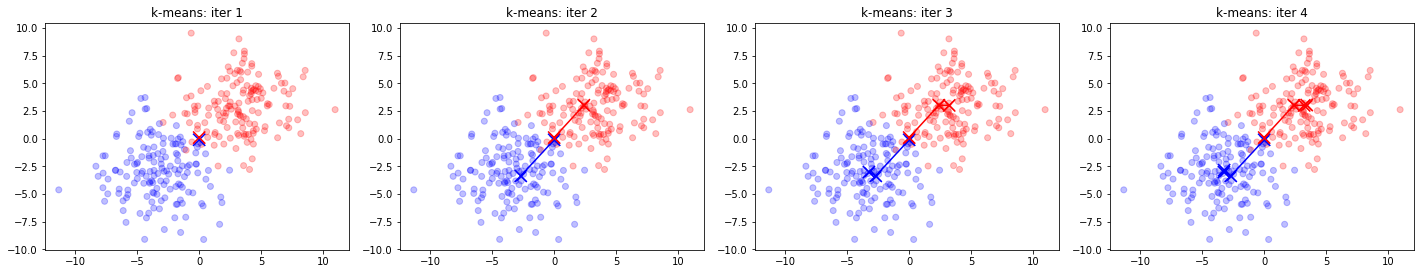

In [3]:
import numpy as np
from sklearn.cluster import KMeans

# initial centroids
centroids=np.array([[0,-0.1], [0,0.1]])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
fig.tight_layout(pad=2.0)

axs[0].set_title('k-means: iter 1')

nearest = lambda p: 0 if np.linalg.norm(p-centroids[0])<np.linalg.norm(p-centroids[1]) else 1
labels = nearest(X)

labels = np.apply_along_axis(nearest, 1, X)

axs[0].scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, alpha=0.25)
axs[0].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

for i, iters in enumerate([1,2,3]):
  kmeans = KMeans(n_clusters=2, init=centroids[:2], n_init=1, max_iter=iters, random_state=23)
  kmeans.fit(X)
  labels = kmeans.predict(X)

  centroids = np.concatenate((centroids, kmeans.cluster_centers_))

  axs[i+1].set_title('k-means: iter ' + str(iters+1))

  axs[i+1].scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, alpha=0.25)
  axs[i+1].scatter(centroids[:,0], centroids[:,1], color=['b','r']*(i+2), marker="x", s=150)
  axs[i+1].plot(centroids[::2,0], centroids[::2,1], color='blue', marker="x", markersize=10)
  axs[i+1].plot(centroids[1::2,0], centroids[1::2,1], color='red', marker="x", markersize=10)


When the training process has finished, the position of the centroids defines $k$ 'basins of atraction' that give rise to $k$ clusters by proximity. This kind of diagram is usually called a Voronoi diagram.

In our case, as we can check in the following image, after the training process most of the points will be correctly classified. Some errors may happen at the boundary between the two original clusters, since the $k$-Means method is intrinsically a metric-based method.

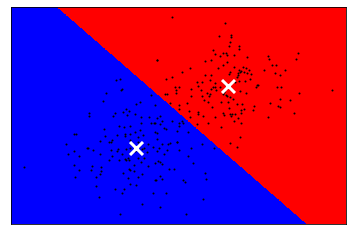

In [4]:
kmeans = KMeans(n_clusters=2, init=centroids[:2], n_init=1, max_iter=3, random_state=23)
kmeans.fit(X)

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02 # step size of the mesh. Decrease to increase the quality of the VQ.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.bwr,
           aspect='auto', origin='lower')

plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Notice that the metric used for computing the distances is crucial for the results. For this reason, several metrics can be used for computing the distances to each cluster. Some of the most common choices are the following:

- Euclidean distance, also known as $L^2$ distance
$$
d_2(x_i,x_j) = \sqrt{(x_{i,1}-x_{j,1})^2 + (x_{i,2}-x_{j,2})^2 + \dots + (x_{i,m}-x_{j,m})^2} = \sqrt{\sum_{f=1}^m (x_{i,f}-x_{j,f})^2}
$$

- $L^p$ distance
$$
d_p(x_i,x_j) = \left(\sum_{f=1}^m |x_{i,f}-x_{j,f}|^p\right)^{1/p}
$$

- Mahalanobis distance
$$
d_M(x_i,x_j) = \sqrt{(x_i-\bar{x})S(x_j-\bar{x})^t},
$$

where $\bar{x}$ is the mean of the values of the dataset and $S$ is its covariance matrix.

## Running example: $K$-Means for MNIST

In this example, we will run the $K$-Means method against the MNIST dataset. Recall that this is a dataset of handwritten digits so the goal is to be able to recover the different digits just through clustering, without any knownledge of the real label.

Hacer clustering al array de X = mnist['data'] para hacer K-means en diez clases. E imprimir

In [22]:
from sklearn.datasets import load_digits
mnist = load_digits()
x = mnist['data']
kmeans = KMeans(n_clusters = 10)
kmeans.fit(x)
kmeans.cluster_centers_

array([[ 0.00000000e+00,  1.99186992e-01,  6.53658537e+00,
         1.25162602e+01,  1.18373984e+01,  5.63821138e+00,
         6.58536585e-01,  8.13008130e-03,  4.06504065e-03,
         2.63414634e+00,  1.40121951e+01,  9.19918699e+00,
         9.44715447e+00,  1.04227642e+01,  1.25203252e+00,
         4.06504065e-03,  1.30104261e-18,  4.32520325e+00,
         1.28414634e+01,  4.52032520e+00,  7.00406504e+00,
         1.11300813e+01,  1.84959350e+00, -6.93889390e-18,
         0.00000000e+00,  2.29268293e+00,  1.03739837e+01,
         1.17886179e+01,  1.32357724e+01,  1.20569106e+01,
         2.48373984e+00,  0.00000000e+00,  0.00000000e+00,
         3.04878049e-01,  3.17073171e+00,  6.09349593e+00,
         6.69105691e+00,  1.12845528e+01,  4.29674797e+00,
         0.00000000e+00,  0.00000000e+00,  2.19512195e-01,
         2.34552846e+00,  1.88211382e+00,  1.60975610e+00,
         1.09512195e+01,  6.42682927e+00,  1.62601626e-02,
         3.46944695e-18,  7.68292683e-01,  8.17479675e+0

In [5]:
from sklearn.datasets import load_digits
mnist = load_digits()

In [6]:
print(mnist['images'][4])
print(mnist['data'][4].reshape((8,8)))

[[ 0.  0.  0.  1. 11.  0.  0.  0.]
 [ 0.  0.  0.  7.  8.  0.  0.  0.]
 [ 0.  0.  1. 13.  6.  2.  2.  0.]
 [ 0.  0.  7. 15.  0.  9.  8.  0.]
 [ 0.  5. 16. 10.  0. 16.  6.  0.]
 [ 0.  4. 15. 16. 13. 16.  1.  0.]
 [ 0.  0.  0.  3. 15. 10.  0.  0.]
 [ 0.  0.  0.  2. 16.  4.  0.  0.]]
[[ 0.  0.  0.  1. 11.  0.  0.  0.]
 [ 0.  0.  0.  7.  8.  0.  0.  0.]
 [ 0.  0.  1. 13.  6.  2.  2.  0.]
 [ 0.  0.  7. 15.  0.  9.  8.  0.]
 [ 0.  5. 16. 10.  0. 16.  6.  0.]
 [ 0.  4. 15. 16. 13. 16.  1.  0.]
 [ 0.  0.  0.  3. 15. 10.  0.  0.]
 [ 0.  0.  0.  2. 16.  4.  0.  0.]]


This dataset contains 1797 images of handwritten digits with a resolution of 8x8 pixels. Each pixel is represented by an integer ranging from 0 to 16 so each image is stored as as 8x8 matrix of integers (or, more precisely, as an array of integers of length 64). There are 10 possible digits (0, 1, ..., 9) and the dataset is balanced, so there are approximately 180 samples of each digit.

The dataset is prepared for easy visualization. The key `images` stores for each sample its 8x8 matrix.

In [7]:
mnist.images[2]

array([[ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.],
       [ 0.,  0.,  3., 16., 15., 14.,  0.,  0.],
       [ 0.,  0.,  8., 13.,  8., 16.,  0.,  0.],
       [ 0.,  0.,  1.,  6., 15., 11.,  0.,  0.],
       [ 0.,  1.,  8., 13., 15.,  1.,  0.,  0.],
       [ 0.,  9., 16., 16.,  5.,  0.,  0.,  0.],
       [ 0.,  3., 13., 16., 16., 11.,  5.,  0.],
       [ 0.,  0.,  0.,  3., 11., 16.,  9.,  0.]])

In [8]:
# Usign Matplotlib we can depict the images

import matplotlib.pyplot as plt

import math
def paint_digits (images):
  for index, image in enumerate(images):
    plt.subplot(math.ceil(len(images)/5), 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

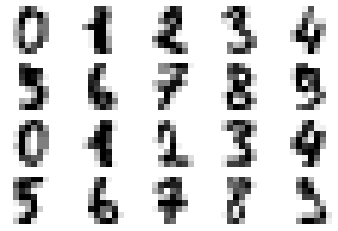

In [9]:
paint_digits(mnist.images[:20])

Evidentemente, esta representación matricial no es adecuada para ser utilizada por un algoritmo de *machine learning*. Necesitamos que cada imagen sea un vector unidimensional.

Como siempre, los datos del dataset se encuentra en el objeto `data`. Observa las diferencias entre ambas codificaciones.

In [10]:
mnist.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [11]:
# Recall that mnist.data also contains de information,
# but as an array (more suitable for training models)

mnist.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Let us apply the $K$-Means algorithm to our dataset. Notice that, since we are dealing with unsupervised learning, we will ignore the `mnist.target` key that contains the real classes of each digit. The aim of this algorithm is precisely to automatically generated these labels.

For the purposes of this example, we will only analyze how the $K$-Means algorithm works. No testing or quality analysis will be conducted. In particular, this implies that there will be no splitting of our dataset into training and testing and all the examples will be used for training $K$-Means.

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, random_state=0)
kmeans.fit(mnist.data)

KMeans(n_clusters=10, random_state=0)

As by-product of the training process, the $K$-Means method generates a centroid for each cluster. This centroid can be thought as the 'prototypical example' of each class. Moreover, the centroid also is a image, so it can be plotted.

The centroids are accesible through the `kmeans.cluster_centers_` attribute.

In [13]:
kmeans.cluster_centers_

array([[ 0.00000000e+00,  5.55111512e-17,  3.07228916e-01,
         7.16265060e+00,  1.19457831e+01,  1.93373494e+00,
         1.50602410e-01,  5.42168675e-02,  2.60208521e-18,
         1.20481928e-02,  3.28313253e+00,  1.37951807e+01,
         8.46385542e+00,  1.53012048e+00,  9.75903614e-01,
         2.77108434e-01,  1.30104261e-18,  6.44578313e-01,
         1.07108434e+01,  1.15602410e+01,  4.33734940e+00,
         5.25903614e+00,  3.87349398e+00,  3.25301205e-01,
         6.02409639e-03,  4.75903614e+00,  1.47590361e+01,
         5.86144578e+00,  6.87951807e+00,  1.07530120e+01,
         6.21686747e+00,  1.80722892e-02,  0.00000000e+00,
         8.92771084e+00,  1.48072289e+01,  9.35542169e+00,
         1.28132530e+01,  1.43915663e+01,  5.48192771e+00,
         0.00000000e+00,  9.63855422e-02,  6.50602410e+00,
         1.16867470e+01,  1.23433735e+01,  1.48373494e+01,
         1.07590361e+01,  1.56626506e+00,  0.00000000e+00,
         6.02409639e-02,  1.11445783e+00,  3.00000000e+0

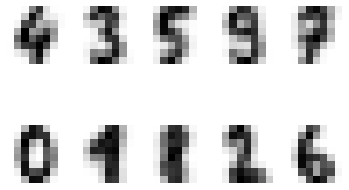

In [14]:
# And we can paint them

paint_digits(list(map(lambda centroid: centroid.reshape(8, 8), kmeans.cluster_centers_)))

This is quite surprising since the algorithm did not receive the real labels at any moment. It learnt 'how to write' by itself.

The obtained solution can be analyzed more thoroughly. Some centroids have similar shape, so it makes sense that they are closer than the others. To compare them, we can use the function `sklearn.metrics.pairwise.euclidean_distances` that computes the distances pairwise of the input data (in our case, taken from `kmeans.cluster_centers_`).

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(kmeans.cluster_centers_, kmeans.cluster_centers_)
dist

array([[ 0.        , 45.02599316, 36.81818104, 39.8514001 , 34.27495448,
        36.2044084 , 33.87880887, 32.05986554, 44.46556741, 31.23159242],
       [45.02599316,  0.        , 34.42019207, 19.16792681, 33.69091942,
        36.61882366, 36.0545591 , 33.29710335, 29.13225602, 41.6495454 ],
       [36.81818104, 34.42019207,  0.        , 30.51642874, 30.14244654,
        37.09824295, 40.45014633, 29.88387331, 33.34081492, 37.65051332],
       [39.8514001 , 19.16792681, 30.51642874,  0.        , 33.64433523,
        28.44196149, 32.49744078, 32.55550608, 31.78621999, 35.38361827],
       [34.27495448, 33.69091942, 30.14244654, 33.64433523,  0.        ,
        41.07242271, 35.84984182, 26.96285536, 37.9646236 , 43.01843166],
       [36.2044084 , 36.61882366, 37.09824295, 28.44196149, 41.07242271,
         0.        , 43.00229732, 39.68469665, 41.54080432, 34.43099679],
       [33.87880887, 36.0545591 , 40.45014633, 32.49744078, 35.84984182,
        43.00229732,  0.        , 33.77842464

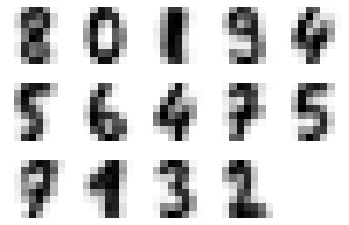

In [16]:
# If we reduce the number of clusters, some of the digits are 'fused'

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 14, random_state=0)
kmeans.fit(mnist.data)

paint_digits(list(map(lambda centroid: centroid.reshape(8, 8), kmeans.cluster_centers_)))

In [17]:
kmeans.labels_

array([1, 2, 0, ..., 0, 3, 0])

## Drawbacks of $K$-Means

In some sense, the $K$-Means algorithm is the 'standard method' of clustering and many variants of it have been proposed. However, it suffers some important flaws that lead to malfunction in some circumstances. 

The most important issue is that $K$-means only can provide **linear separation of the data**. The Voronoi diagram generated by the centroids is intrinsically piecewise linear, so no complex separations can be expected from $K$-Means.

Let us analyze this by running it against several datasets.

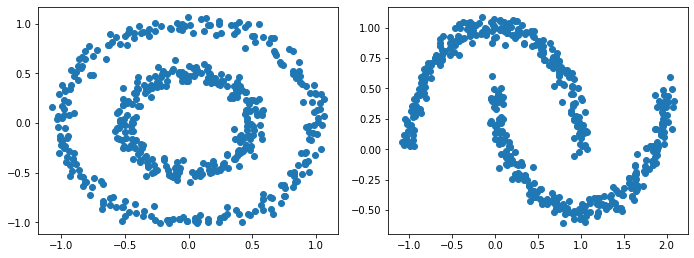

In [22]:
from sklearn import datasets

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.tight_layout(pad=2.0)

circles, _ = datasets.make_circles(n_samples=500, factor=.5, noise=.05, random_state=23)
axs[0].scatter(circles[:,0], circles[:,1])

moons, _ = datasets.make_moons(n_samples=500, noise=.05, random_state=23)
axs[1].scatter(moons[:,0], moons[:,1])

These two clusters as strongly non-linearly separable. For this reason, $K$-Means cannot detect them for two clusters (`k=2`).

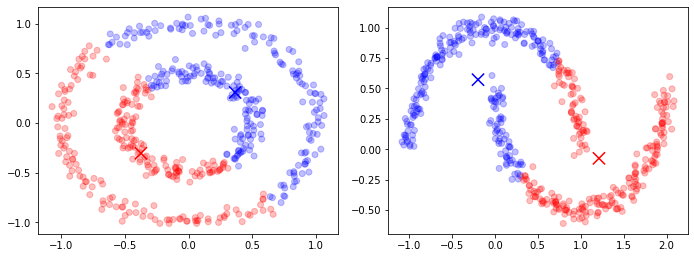

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.tight_layout(pad=2.0)

kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(circles)

labels = kmeans.predict(circles)
centroids = kmeans.cluster_centers_

axs[0].scatter(circles[:,0], circles[:,1], c=plt.cm.brg(labels/2, alpha=.25))
axs[0].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(moons)

labels = kmeans.predict(moons)
centroids = kmeans.cluster_centers_

axs[1].scatter(moons[:,0], moons[:,1], c=plt.cm.brg(labels/2, alpha=.25))
axs[1].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

Since the algorithm is not able to separate the clusters, they move until they 'capture' almost the same mass of the picture.

Another important issue of $K$-Means is that it is very sensitive to **outliers**. As the mean itself, the computation of the centroids in $K$-Means is strongly affected by strange values, generaly leading to an anomalous move of the centroids.

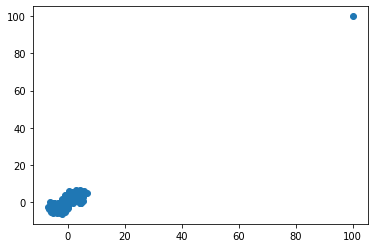

In [24]:
# Consider the following dataset with a single point on the top right corner

blobs, _ = make_blobs(n_samples=300, n_features=2, centers=[[-3,-3], [3,3]], cluster_std=1.5, random_state=23)
blobs = np.concatenate((blobs, np.array([[100,100]])))

plt.figure()
plt.scatter(blobs[:,0], blobs[:,1])

If we apply $K$-Means, all the points of the bottom left part of the picture are assigned to the same cluster, even though we know they were generated with two different gaussian distributions. The uppermost point hoards a centroid for itself, creating a cluster with only one element.

In order to address this problem, a previous filtering of the anomalous data can be carried out to remove these outliers.

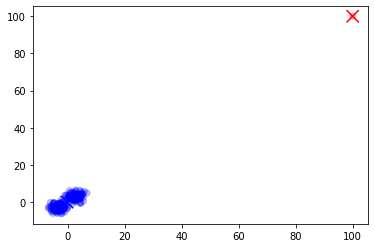

In [27]:
kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(blobs)

labels = kmeans.predict(blobs)
centroids = kmeans.cluster_centers_

plt.figure()
plt.scatter(blobs[:,0], blobs[:,1], c=plt.cm.brg(labels/2, alpha=.25))
plt.scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

Finally, notice that the computation of the distances between each point and the centroids for each iteration is extremely heavy and slow with the dataset is large. To overcome this issue, there exists a variant of the $K$-Means algorithm, known as **Mini Batch k-Means** and available in `sklearn` in the class [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

The idea of this variant is that, instead of computing the centroid with all the instances of the dataset, it picks a random sample to analize. The effect of this choice is threefold: the time required for each iteration drastically decreases, the overfitting reduces and the impact of the outliers is reduced. However, it introduces an extra hyper-parameter to optimize: the number of random samples to be picked for each iteration (the size of the batch).

---

Created by **Fernando Ortega** (fernando.ortega@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">